# EEG emotion recognition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 7)

## Dataset extraction

Let us explore more about our dataset.

In [2]:
# read data
data = pd.read_csv('./emotions.csv')
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


As we can see, the dataset contains a lot of features, such as mean values, minimal and maximal ones, etc.

However, I suggest to concentrate on results of Fourier Transform of each signal.

Divide data into labels and features.

In [3]:
data_labels = data['label']
data.drop('label', axis = 1, inplace=True)

In [4]:
data_fft = data.loc[:,'fft_0_b':'fft_749_b']
data_fft.head()

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60


In [5]:
data_fft.describe()

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,-44.697430,117.945707,-61.129237,-61.129237,117.945707,-19.942029,102.733410,-52.112550,-52.112550,102.733410,...,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,282.126882,202.274870,102.957227,102.957227,202.274870,303.924090,214.518033,115.677682,115.677682,214.518033,...,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976
min,-1160.000000,-647.000000,-483.000000,-483.000000,-647.000000,-1290.000000,-1050.000000,-497.000000,-497.000000,-1050.000000,...,-1180.000000,-921.000000,-504.000000,-504.000000,-921.000000,-1160.000000,-1010.000000,-521.000000,-521.000000,-1010.000000
25%,-173.250000,-5.857500,-108.000000,-108.000000,-5.857500,-120.250000,-10.500000,-97.025000,-97.025000,-10.500000,...,-106.500000,-8.365000,-92.900000,-92.900000,-8.365000,-102.500000,-8.837500,-87.150000,-87.150000,-8.837500
50%,71.950000,14.550000,-29.550000,-29.550000,14.550000,86.550000,10.700000,-21.200000,-21.200000,10.700000,...,83.850000,12.150000,-21.800000,-21.800000,12.150000,89.700000,13.400000,-24.100000,-24.100000,13.400000
75%,140.000000,231.000000,5.715000,5.715000,231.000000,154.250000,179.000000,13.000000,13.000000,179.000000,...,154.000000,177.000000,12.025000,12.025000,177.000000,153.000000,149.250000,10.925000,10.925000,149.250000
max,963.000000,885.000000,975.000000,975.000000,885.000000,1320.000000,904.000000,1800.000000,1800.000000,904.000000,...,1070.000000,843.000000,1490.000000,1490.000000,843.000000,1180.000000,888.000000,1670.000000,1670.000000,888.000000


## Spectrum examples

The first three rows in the dataset contain results for Negative, Neutral and Positive labelled emotions. Let us take a look at how do the spetrums of different emotions look!

Text(0, 0.5, 'spectrum magnitude')

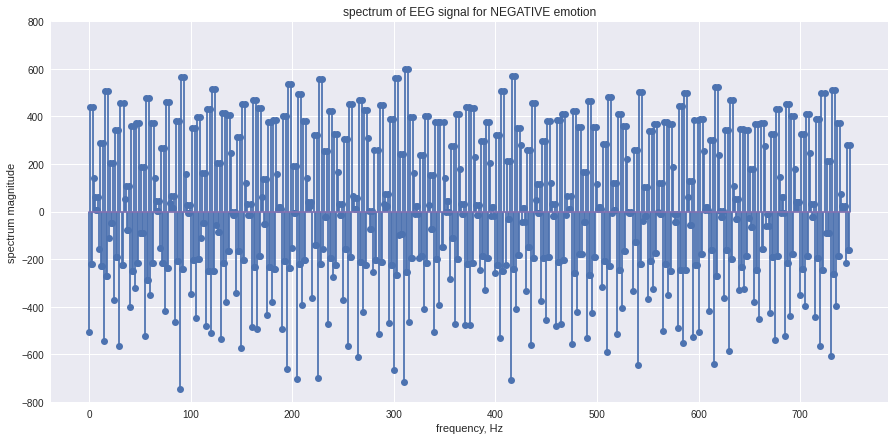

In [6]:
plt.stem(data_fft.to_numpy()[0])
plt.title('spectrum of EEG signal for NEGATIVE emotion')
plt.ylim([-800, 800])
plt.xlabel('frequency, Hz')
plt.ylabel('spectrum magnitude')

Text(0, 0.5, 'spectrum magnitude')

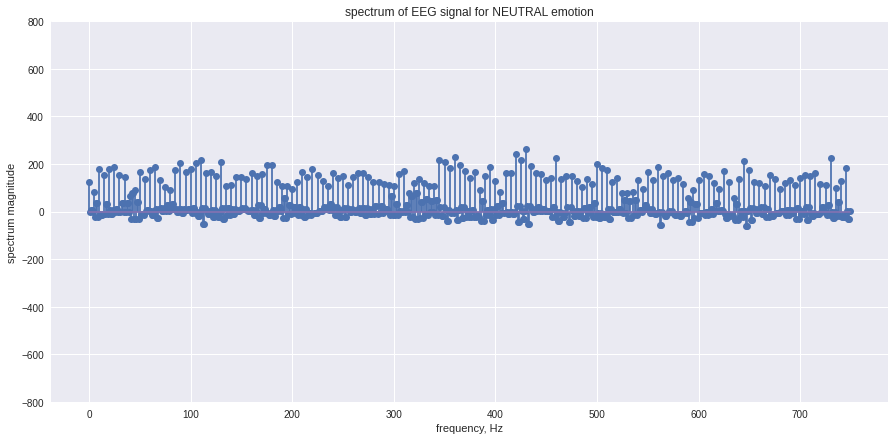

In [7]:
plt.stem(data_fft.to_numpy()[1])
plt.title('spectrum of EEG signal for NEUTRAL emotion')
plt.ylim([-800, 800])
plt.xlabel('frequency, Hz')
plt.ylabel('spectrum magnitude')

Text(0, 0.5, 'spectrum magnitude')

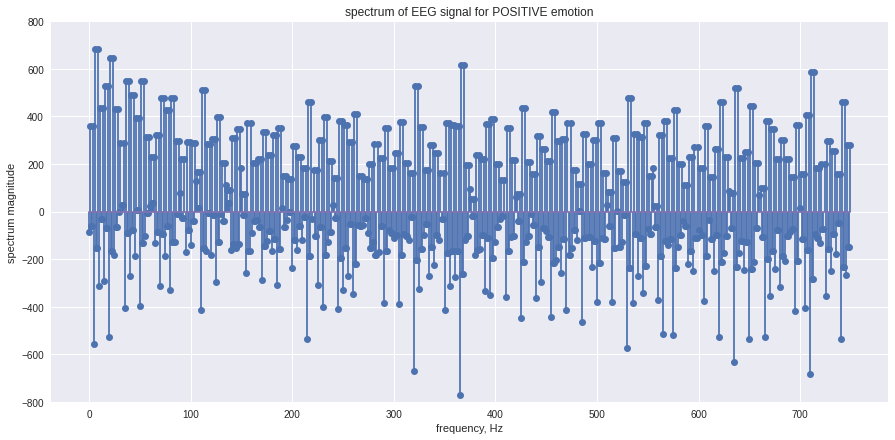

In [8]:
plt.stem(data_fft.to_numpy()[2])
plt.title('spectrum of EEG signal for POSITIVE emotion')
plt.ylim([-800, 800])
plt.xlabel('frequency, Hz')
plt.ylabel('spectrum magnitude')

Now, let us train KNN classifier and see its performance.

In [9]:
pipeline_knn = Pipeline(steps=[('scaler', MinMaxScaler()),
                             ('knn', KNeighborsClassifier(n_neighbors=3))])

accuracies = cross_val_score(pipeline_knn, data_fft, data_labels, cv=10, scoring='accuracy')
accuracy = accuracies.mean()
print(f'Accuracy for KNN with 4 neighbors: {accuracy}')

Accuracy for KNN with 4 neighbors: 0.960137773682594


In [10]:
pipeline_logit = Pipeline(steps=[('scaler', MinMaxScaler()),
                             ('log_reg', LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='saga', max_iter=400))])
accuracies = cross_val_score(pipeline_logit, data_fft, data_labels, cv=10, scoring='accuracy')
print(f'Accuracy for Logistig regression: {accuracy}')

/home/sophmintaii/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sophmintaii/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sophmintaii/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sophmintaii/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sophmintaii/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/sophmintaii/.local/lib/python3.9/site-packages/sklearn

Accuracy for Logistig regression: 0.960137773682594


/home/sophmintaii/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Ooops, it looks like using Logistic Regression model for our data is not a good idea - it does not converge :(

In [11]:
pipeline_random_forest = Pipeline(steps=[('random_forest', RandomForestClassifier())])

accuracies = cross_val_score(pipeline_random_forest, data_fft, data_labels, cv=10, scoring='accuracy')
print(f'Accuracy for Logistig regression: {accuracy}')

Accuracy for Logistig regression: 0.960137773682594
